# There are Dow Jones records of 5.5 months of changes in 30 different stocks.

## TASK: Our goal in this project is to build ONE general model and predict the changes of all stocks for the next week.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("./DATA/Dow Jones Index/dow_jones_index.data")
df_copy = df.copy()
df.head()

,quarter,stock,date,open,high,low,close,volume,percent_change_price,percent_change_volume_over_last_wk,previous_weeks_volume,next_weeks_open,next_weeks_close,percent_change_next_weeks_price,days_to_next_dividend,percent_return_next_dividend
0,1,AA,1/7/2011,$15.82,$16.72,$15.78,$16.42,239655616,3.79267,NaN,NaN,$16.71,$15.97,-4.428490,26,0.182704
1,1,AA,1/14/2011,$16.71,$16.71,$15.64,$15.97,242963398,-4.42849,1.380223,239655616.0,$16.19,$15.79,-2.470660,19,0.187852
2,1,AA,1/21/2011,$16.19,$16.38,$15.60,$15.79,138428495,-2.47066,-43.024959,242963398.0,$15.87,$16.13,1.638310,12,0.189994
3,1,AA,1/28/2011,$15.87,$16.63,$15.82,$16.13,151379173,1.63831,9.355500,138428495.0,$16.18,$17.14,5.933250,5,0.185989
4,1,AA,2/4/2011,$16.18,$17.39,$16.18,$17.14,154387761,5.93325,1.987452,151379173.0,$17.33,$17.37,0.230814,97,0.175029


In [3]:
df.shape

(750, 16)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 16 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quarter                             750 non-null    int64  
 1   stock                               750 non-null    object 
 2   date                                750 non-null    object 
 3   open                                750 non-null    object 
 4   high                                750 non-null    object 
 5   low                                 750 non-null    object 
 6   close                               750 non-null    object 
 7   volume                              750 non-null    int64  
 8   percent_change_price                750 non-null    float64
 9   percent_change_volume_over_last_wk  720 non-null    float64
 10  previous_weeks_volume               720 non-null    float64
 11  next_weeks_open                     750 non-n

In [5]:
obj_to_float_cols = ['open', 'high' , 'low' , 'close' , 'next_weeks_open' , 'next_weeks_close']

for col in obj_to_float_cols:
    df[col] = df[col].str.replace('$' , '').astype(float)

In [6]:
# Lets convert date column to datetime data type
df['date'] = pd.to_datetime(df['date'])

# Add year feature
df['year'] = df['date'].dt.year

# Add month feature
df['month'] = df['date'].dt.month

# Add day feature
df['day'] = df['date'].dt.day

# Add Weekday/Weekend and Month of year features.
df['weekday'] = df['date'].dt.weekday  # Monday: 0, Sunday: 6
df['month_of_year'] = df['date'].dt.month

# Add Week of the Year feature
df['week_of_year'] = df['date'].dt.isocalendar().week # Haftanın numarası olarak

df.drop('date' , axis = 1 , inplace= True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   quarter                             750 non-null    int64  
 1   stock                               750 non-null    object 
 2   open                                750 non-null    float64
 3   high                                750 non-null    float64
 4   low                                 750 non-null    float64
 5   close                               750 non-null    float64
 6   volume                              750 non-null    int64  
 7   percent_change_price                750 non-null    float64
 8   percent_change_volume_over_last_wk  720 non-null    float64
 9   previous_weeks_volume               720 non-null    float64
 10  next_weeks_open                     750 non-null    float64
 11  next_weeks_close                    750 non-n

# Train | Test Split

In [14]:
df['stock'] = df['stock'].astype('category') # For XGBoost
df['week_of_year'] = df['week_of_year'].astype(int) # For XGBoost

cat_cols_neccessary = ['stock'] # For CatBoost

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop('percent_change_next_weeks_price' , axis = 1)
y = df['percent_change_next_weeks_price']

X_train , X_test , y_train , y_test = train_test_split(X, y, test_size= 0.2 , random_state= 53)

In [10]:
print(f"X shape: {X.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X shape: (750, 20)
X_train shape: (600, 20)
X_test shape: (150, 20)


In [11]:
from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score

def eval_metrics(y_test , y_pred):
    print(f"R2 Score: {r2_score(y_test,  y_pred)}")
    print(f"RMSE: {mean_squared_error(y_test,  y_pred)**0.5}")
    print(f"MAE: {mean_absolute_error(y_test,  y_pred)}")
    print(f"MSE: {mean_squared_error(y_test,  y_pred)}")

    target_mean = df['percent_change_next_weeks_price'].abs().mean()
    loss_perc = mean_absolute_error(y_test,  y_pred) / target_mean * 100
    print(f'\n\nTarget Mean: {target_mean:.2f}')
    print(f"Loss percentage : {loss_perc:.2f}%")

# Modelling

## CatBoost Model

In [15]:
from catboost import CatBoostRegressor

cb = CatBoostRegressor(cat_features= cat_cols_neccessary)

cb.fit(X_train , y_train)

y_pred = cb.predict(X_test)

Learning rate set to 0.037768
0:	learn: 2.5548070	total: 155ms	remaining: 2m 35s
1:	learn: 2.5392320	total: 168ms	remaining: 1m 23s
2:	learn: 2.5236986	total: 181ms	remaining: 1m
3:	learn: 2.5051618	total: 192ms	remaining: 47.9s
4:	learn: 2.4898418	total: 207ms	remaining: 41.2s
5:	learn: 2.4681170	total: 217ms	remaining: 35.9s
6:	learn: 2.4515830	total: 231ms	remaining: 32.8s
7:	learn: 2.4427499	total: 242ms	remaining: 30s
8:	learn: 2.4207663	total: 253ms	remaining: 27.9s
9:	learn: 2.4018199	total: 263ms	remaining: 26.1s
10:	learn: 2.3839540	total: 274ms	remaining: 24.6s
11:	learn: 2.3715502	total: 285ms	remaining: 23.5s
12:	learn: 2.3610151	total: 296ms	remaining: 22.5s
13:	learn: 2.3460105	total: 307ms	remaining: 21.6s
14:	learn: 2.3353886	total: 317ms	remaining: 20.8s
15:	learn: 2.3249869	total: 329ms	remaining: 20.2s
16:	learn: 2.3137810	total: 340ms	remaining: 19.7s
17:	learn: 2.2958406	total: 350ms	remaining: 19.1s
18:	learn: 2.2868098	total: 361ms	remaining: 18.6s
19:	learn: 2.2

In [16]:
eval_metrics(y_test , y_pred)

R2 Score: 0.266764415402843
RMSE: 2.5966333653798572
MAE: 1.7446090740527147
MSE: 6.742504834203924


Target Mean: 2.01
Loss percentage : 86.72%


### Optuna CatBoost

In [17]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Veri setinizi yükleyin ve böylece tüm kod parçacıklarını tek bir örnekte kullanabilmek için veriyi yeniden ayarlayın

def objective(trial):
    # Hyperparametrelerinizi belirleyin
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 1e2),
    }

    # CatBoost modelini oluşturun
    model = CatBoostRegressor(cat_features=cat_cols_neccessary, **params, verbose=0)

    # Modeli eğitin
    model.fit(X_train, y_train)

    # Tahminleri yapın
    y_pred = model.predict(X_test)

    # Ortalama kare hata (MSE) hesaplayın (minimize etmek istediğimiz metrik)
    mse = mean_squared_error(y_test, y_pred)

    return mse

# Veriyi train ve test olarak ayırın
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=53)

# Optuna'nın optimize edeceği hiperparametreleri belirleyin
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)  # Denenecek hiperparametre kombinasyonlarının sayısını belirleyin

# En iyi hiperparametreleri ve en düşük MSE değerini görüntüleyin
best_params = study.best_params
best_mse = study.best_value

print("En iyi hiperparametreler:", best_params)
print("En düşük MSE:", best_mse)

# En iyi hiperparametrelerle nihai CatBoost modelini oluşturun
best_model = CatBoostRegressor(cat_features=cat_cols_neccessary, **best_params, verbose=0)
best_model.fit(X_train, y_train)

# Tahminleri yapın
y_pred = best_model.predict(X_test)

[I 2023-09-28 14:00:02,823] A new study created in memory with name: no-name-04ac9c22-e828-4a1a-97a2-6ef19df296c0
[I 2023-09-28 14:00:33,172] Trial 0 finished with value: 6.934862943294946 and parameters: {'iterations': 966, 'learning_rate': 0.22434757329992341, 'depth': 10, 'l2_leaf_reg': 42.983978556429385}. Best is trial 0 with value: 6.934862943294946.
[I 2023-09-28 14:00:38,751] Trial 1 finished with value: 7.8358669628326245 and parameters: {'iterations': 301, 'learning_rate': 0.02035684036196092, 'depth': 9, 'l2_leaf_reg': 85.74698870352968}. Best is trial 0 with value: 6.934862943294946.
[I 2023-09-28 14:00:39,671] Trial 2 finished with value: 7.0513199879343516 and parameters: {'iterations': 119, 'learning_rate': 0.2719396853732938, 'depth': 4, 'l2_leaf_reg': 75.26535386215858}. Best is trial 0 with value: 6.934862943294946.
[I 2023-09-28 14:00:46,571] Trial 3 finished with value: 7.031661213999893 and parameters: {'iterations': 702, 'learning_rate': 0.25436817985273763, 'dept

En iyi hiperparametreler: {'iterations': 866, 'learning_rate': 0.19040477019850724, 'depth': 4, 'l2_leaf_reg': 0.02385991461847059}
En düşük MSE: 5.8094933314931865


In [21]:
best_cb = CatBoostRegressor(**{'iterations': 866, 'learning_rate': 0.19040477019850724, 'depth': 4, 'l2_leaf_reg': 0.02385991461847059} , cat_features= cat_cols_neccessary)

best_cb.fit(X_train , y_train)

y_pred = best_cb.predict(X_test)

eval_metrics(y_test , y_pred)

0:	learn: 2.4643598	total: 11.3ms	remaining: 9.81s
1:	learn: 2.4023128	total: 21.8ms	remaining: 9.42s
2:	learn: 2.3591312	total: 33.3ms	remaining: 9.58s
3:	learn: 2.2837432	total: 42.6ms	remaining: 9.17s
4:	learn: 2.2536119	total: 50.5ms	remaining: 8.7s
5:	learn: 2.2073690	total: 57.8ms	remaining: 8.28s
6:	learn: 2.1700523	total: 66.4ms	remaining: 8.15s
7:	learn: 2.1468814	total: 75.1ms	remaining: 8.06s
8:	learn: 2.1167131	total: 82.4ms	remaining: 7.84s
9:	learn: 2.1043988	total: 92.6ms	remaining: 7.93s
10:	learn: 2.0851451	total: 100ms	remaining: 7.79s
11:	learn: 2.0721749	total: 110ms	remaining: 7.81s
12:	learn: 2.0309846	total: 117ms	remaining: 7.71s
13:	learn: 2.0188004	total: 124ms	remaining: 7.58s
14:	learn: 2.0080563	total: 132ms	remaining: 7.51s
15:	learn: 2.0026812	total: 140ms	remaining: 7.44s
16:	learn: 1.9912493	total: 148ms	remaining: 7.38s
17:	learn: 1.9829299	total: 155ms	remaining: 7.29s
18:	learn: 1.9792305	total: 163ms	remaining: 7.25s
19:	learn: 1.9617394	total: 170m

## XGBoost

In [32]:
from xgboost import XGBRegressor

xgb = XGBRegressor(tree_method = 'gpu_hist', gpu_id = 0, n_estimators = 1000, learning_rate = 0.1, max_depth = 6, enable_categorical= True)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

In [33]:
eval_metrics(y_test , y_pred)

R2 Score: 0.22624221588175242
RMSE: 2.6674198705093883
MAE: 1.8456369980427523
MSE: 7.115128765588321


Target Mean: 2.01
Loss percentage : 91.75%


In [ ]:
# Bad results with one general model with ensemble.

# Linear Regression

We will try simple linear regression this time !

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   quarter                             750 non-null    int64   
 1   stock                               750 non-null    category
 2   open                                750 non-null    float64 
 3   high                                750 non-null    float64 
 4   low                                 750 non-null    float64 
 5   close                               750 non-null    float64 
 6   volume                              750 non-null    int64   
 7   percent_change_price                750 non-null    float64 
 8   percent_change_volume_over_last_wk  720 non-null    float64 
 9   previous_weeks_volume               720 non-null    float64 
 10  next_weeks_open                     750 non-null    float64 
 11  next_weeks_close                

In [50]:
df = df.iloc[:, :-5]

In [51]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['stock'] = le.fit_transform(df['stock']) # For LinearRegression
df = df.dropna()

In [52]:
from sklearn.model_selection import train_test_split

X = df.drop('percent_change_next_weeks_price' , axis = 1)
y = df['percent_change_next_weeks_price']

X_train , X_test , y_train , y_test = train_test_split(X, y, test_size= 0.2 , random_state= 53)


print(f"X shape: {X.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X shape: (720, 15)
X_train shape: (576, 15)
X_test shape: (144, 15)


c:\Users\Emincan\miniconda3\envs\ml\lib\site-packages\matplotlib\colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


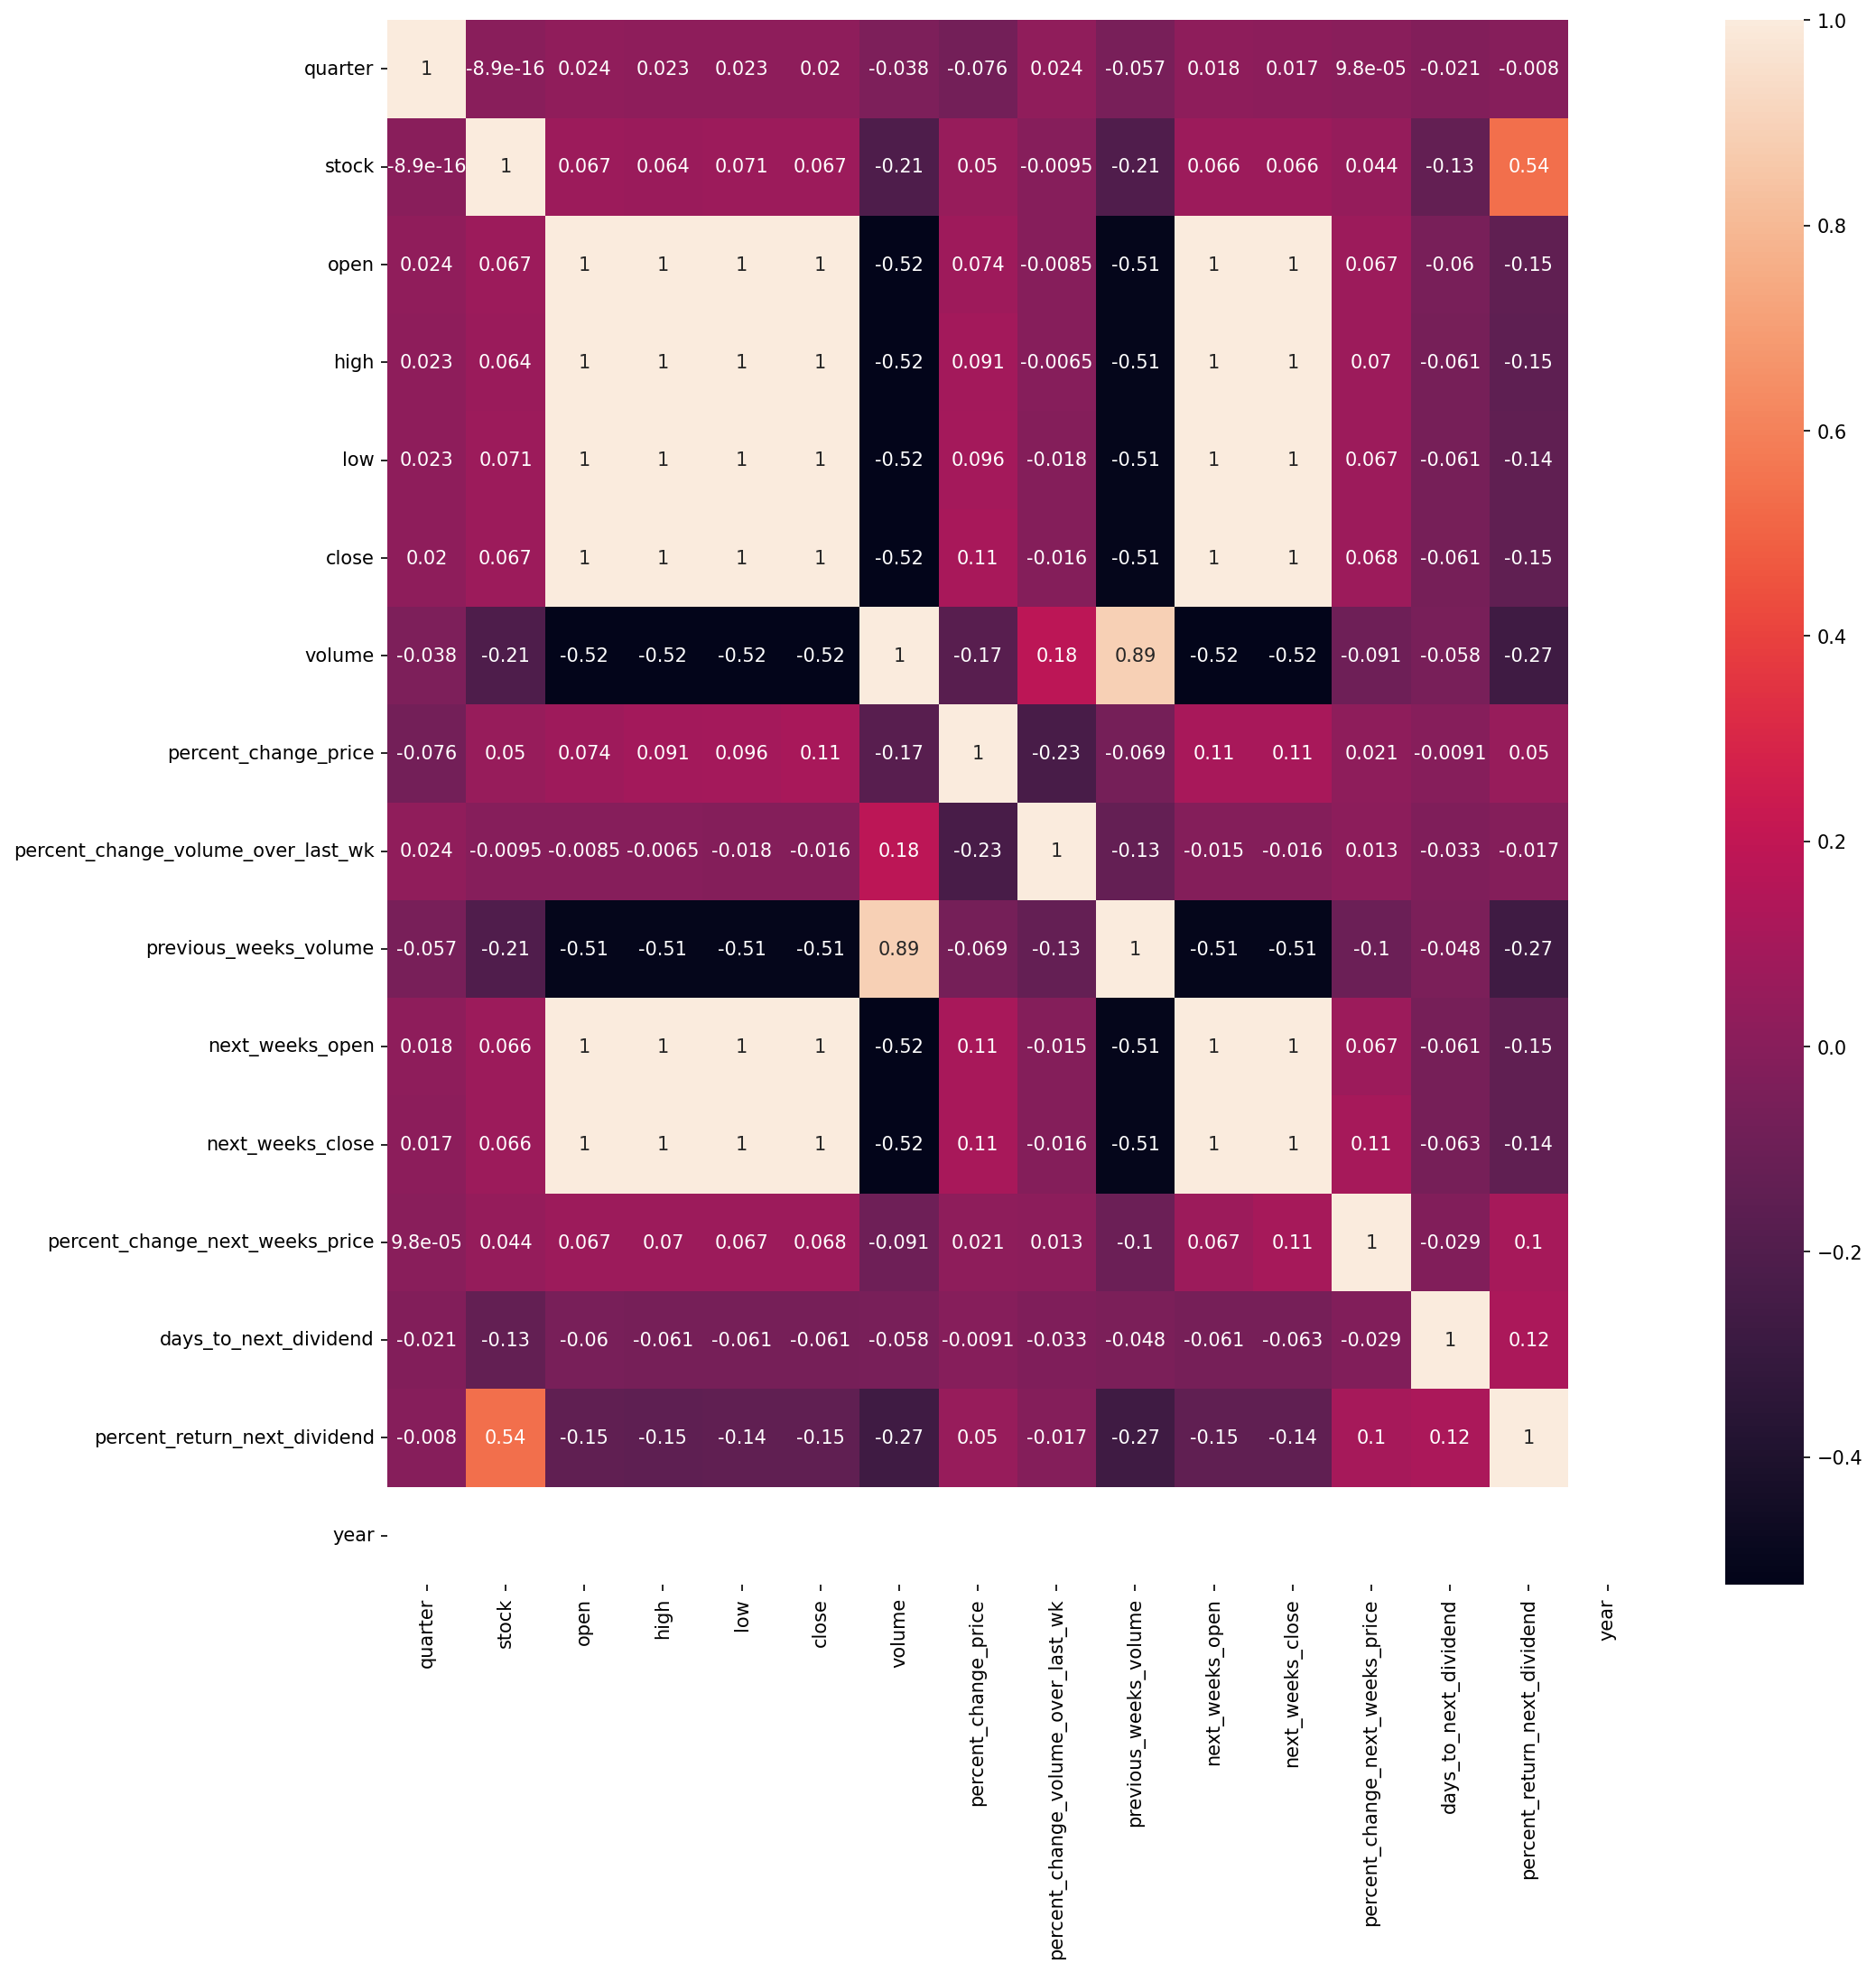

In [53]:
plt.figure(figsize= (15,15) , dpi= 150)

sns.heatmap(df.corr() , annot= True);

In [54]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

In [55]:
eval_metrics(y_test , y_pred)

R2 Score: 0.6829289087093133
RMSE: 1.5415727281596332
MAE: 0.9917729333297497
MSE: 2.3764464762055346


Target Mean: 2.00
Loss percentage : 49.70%


In [ ]:
# Linear Model better than ensembles. Lol its funny.